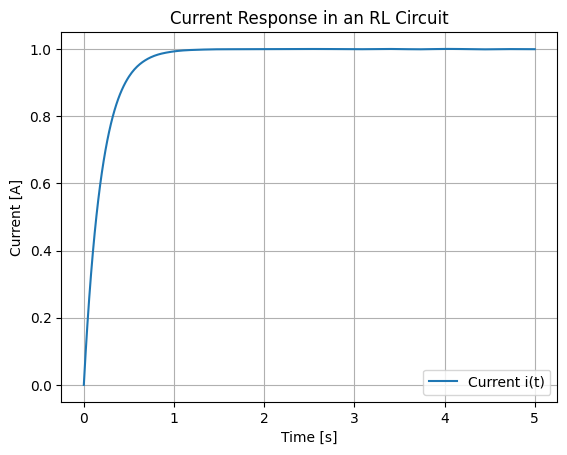

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the ODE for the RL circuit
def rl_circuit(t, i, V, R, L):
    di_dt = (V(t) - R * i) / L
    return di_dt

# Input voltage as a function of time (e.g., constant voltage of 10V)
def V_constant(t):
    return 10

# Time span for the simulation
t_start = 0
t_end = 5
t_eval = np.linspace(t_start, t_end, 500)

# RL circuit parameters
R = 10  # Resistance in ohms
L = 2   # Inductance in henries
i_initial = [0]  # Initial current (starting at 0 A)

# Solve the ODE
solution = solve_ivp(rl_circuit, [t_start, t_end], i_initial, t_eval=t_eval, args=(V_constant, R, L))

# Plot the result
plt.plot(solution.t, solution.y[0], label="Current i(t)")
plt.title('Current Response in an RL Circuit')
plt.xlabel('Time [s]')
plt.ylabel('Current [A]')
plt.grid(True)
plt.legend()
plt.show()


Epoch 0, Total Loss: 61.899281, Data Loss: 0.568979, Physics Loss: 61.330303
Epoch 100, Total Loss: 0.184001, Data Loss: 0.010316, Physics Loss: 0.173685
Epoch 200, Total Loss: 0.030894, Data Loss: 0.014417, Physics Loss: 0.016477
Epoch 300, Total Loss: 0.023823, Data Loss: 0.015829, Physics Loss: 0.007993
Epoch 400, Total Loss: 0.021835, Data Loss: 0.016303, Physics Loss: 0.005532
Epoch 500, Total Loss: 0.020633, Data Loss: 0.016663, Physics Loss: 0.003970
Epoch 600, Total Loss: 0.019966, Data Loss: 0.016954, Physics Loss: 0.003012
Epoch 700, Total Loss: 0.019614, Data Loss: 0.017176, Physics Loss: 0.002438
Epoch 800, Total Loss: 0.019423, Data Loss: 0.017338, Physics Loss: 0.002085
Epoch 900, Total Loss: 0.019307, Data Loss: 0.017454, Physics Loss: 0.001853
Epoch 1000, Total Loss: 0.019222, Data Loss: 0.017536, Physics Loss: 0.001687
Epoch 1100, Total Loss: 0.019152, Data Loss: 0.017594, Physics Loss: 0.001558
Epoch 1200, Total Loss: 0.019089, Data Loss: 0.017638, Physics Loss: 0.001

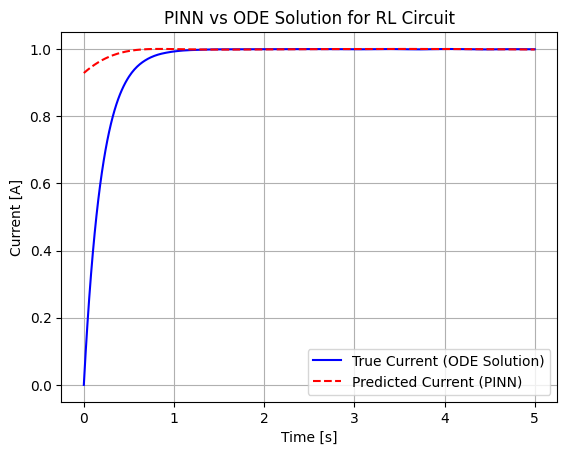

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the neural network architecture (simple feed-forward network)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        
    def forward(self, t):
        return self.layers(t)

# Generate training data by solving the ODE (for supervised learning part)
def rl_circuit(t, i, V, R, L):
    di_dt = (V(t) - R * i) / L
    return di_dt

def V_constant(t):
    return 10

# Solve the ODE to generate data
t_start = 0
t_end = 5
t_eval = np.linspace(t_start, t_end, 500)
R = 10  # Resistance
L = 2   # Inductance
i_initial = [0]  # Initial current
solution = solve_ivp(rl_circuit, [t_start, t_end], i_initial, t_eval=t_eval, args=(V_constant, R, L))

# Supervised data (time and current)
t_train = torch.tensor(t_eval, dtype=torch.float32).reshape(-1, 1)
i_train = torch.tensor(solution.y[0], dtype=torch.float32).reshape(-1, 1)

# Physics-Informed Loss (RL Circuit ODE)
def physics_loss(model, t, R, L, V):
    t = t.requires_grad_(True)  # Enable gradients w.r.t time
    i_pred = model(t)  # Predicted current i(t)
    
    # Compute di/dt using autograd
    di_dt = torch.autograd.grad(i_pred, t, torch.ones_like(t), create_graph=True)[0]
    
    # ODE: V(t) = L * di/dt + R * i(t)
    residual = V(t) - (L * di_dt + R * i_pred)
    return torch.mean(residual ** 2)

# Define the training loop
def train_pinn(model, t_train, i_train, R, L, V, epochs=1000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()

        # Supervised data loss (compare model predictions with actual data)
        i_pred = model(t_train)
        data_loss = loss_fn(i_pred, i_train)

        # Physics loss (ensure predictions satisfy the RL ODE)
        phys_loss = physics_loss(model, t_train, R, L, V)

        # Total loss (weighted sum of data loss and physics loss)
        total_loss = data_loss + phys_loss

        # Backpropagation and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Print the training progress
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Total Loss: {total_loss.item():.6f}, Data Loss: {data_loss.item():.6f}, Physics Loss: {phys_loss.item():.6f}')

# Define the constant voltage function for the physics loss
def V_constant_torch(t):
    return torch.full_like(t, 10.0)

# Initialize the model
pinn_model = PINN()

# Train the PINN
train_pinn(pinn_model, t_train, i_train, R, L, V_constant_torch, epochs=2000)

# Evaluate the trained model and plot the results
pinn_model.eval()
with torch.no_grad():
    i_pred_pinn = pinn_model(t_train).numpy()

# Plot the results
plt.plot(t_eval, solution.y[0], label='True Current (ODE Solution)', color='blue')
plt.plot(t_eval, i_pred_pinn, label='Predicted Current (PINN)', color='red', linestyle='dashed')
plt.title('PINN vs ODE Solution for RL Circuit')
plt.xlabel('Time [s]')
plt.ylabel('Current [A]')
plt.legend()
plt.grid(True)
plt.show()
